# Librerias, preparación de los datos y funciones generales









### Packages

In [1]:
!pip install arch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 903 kB 3.2 MB/s 


In [2]:
!pip install pmdarima

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.8 MB 3.2 MB/s 
     |████████████████████████████████| 9.8 MB 58.3 MB/s 
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.12.2
    Uninstalling statsmodels-0.12.2:
      Successfully uninstalled statsmodels-0.12.2


In [3]:
import numpy as np
import pandas as pd
import scipy
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from statsmodels.tsa.arima_model import ARIMA
from arch import arch_model
import seaborn as sns
import warnings
import math
warnings.filterwarnings("ignore")
sns.set()

### Loading the data

In [4]:
# Cargamos los datos
df = pd.read_csv('./BTCUSDT1h-18.8.17-31-7-22.csv',index_col=0, parse_dates=True)
df=df.drop(columns=['ignore'])
df=df.drop(columns=['open_time'])
df=df.drop(columns=['close_time'])
df.head()
#Variables del dataset
n_obs=math.floor(72)
freq='1h'


In [5]:
#adaptación
df=df.asfreq(freq)
df=df.fillna(method='ffill')
df.isnull().sum()
#Check
nan_rows = df[df.isnull().any(1)]
nan_rows

,open,high,low,close,volume,qav,num_trades,taker_base_vol,taker_quote_vol
Date,,,,,,,,,


### Splitting the Data

In [6]:
#train test una variable
df1 = df.drop(['open', 'high','low', 'volume', 'qav','num_trades', 'taker_base_vol','taker_quote_vol'], axis=1)
df1_train, df1_test = df1[0:-n_obs], df1[-n_obs:]

## Selección de fechas

In [7]:
# create variables that will help us change the periods easily instead of typing them up every time
# make sure the start and end dates are business days, otherwise the code will result in an error
start_date = "2022-07-30 13:59:59.999"
end_date = "2022-07-31 00:59:59.999"

### Función para representar los resultados

In [8]:
warnings.simplefilter('ignore')
from sklearn.metrics import mean_absolute_error, mean_squared_error

def show_graphp1(data,title):
    data.reset_index(inplace=True, drop=True)

    for col in data.columns:
        if col.lower().startswith('predicted_mean'):
            data[col].plot(label=col,linestyle="dotted")
        else:
            data[col].plot(label=col)

    plt.rcParams["figure.figsize"] = (20, 10)
    plt.title(title)
    plt.legend()
    plt.show()
    print ()
    print('Evaluated model:', title)
    print('Mean absolute error:', mean_absolute_error(data['close'].values,data['predicted_mean'].values))
    print('Root mean squared error:', np.sqrt(mean_squared_error(data['close'].values,data['predicted_mean'].values)))

In [9]:
warnings.simplefilter('ignore')

def show_graphp2(data,title):
    data.reset_index(inplace=True, drop=True)
    data=data.iloc[43200:]

    for col in data.columns:
        if col.lower().startswith('predicted_mean'):
            data[col].plot(label=col,linestyle="dotted")
        else:
            data[col].plot(label=col)

    plt.rcParams["figure.figsize"] = (20, 10)
    plt.title(title)
    plt.legend()
    plt.show()
   

#Modelo AUTO ARIMA simple

### Fitting a Model

In [11]:
from pmdarima.arima import auto_arima

In [8]:
model_auto = auto_arima(df1_train)

In [9]:
model_auto

ARIMA(order=(4, 1, 4), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

In [10]:
model_auto.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                43321
Model:               SARIMAX(4, 1, 4)   Log Likelihood             -294447.036
Date:                Sun, 18 Sep 2022   AIC                         588912.073
Time:                        17:58:24   BIC                         588990.160
Sample:                    08-18-2017   HQIC                        588936.698
                         - 07-28-2022                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0508      0.041      1.251      0.211      -0.029       0.131
ar.L2          0.5683      0.036     15.870      0.000       0.498       0.638
ar.L3          0.2057      0.026      7.847      0.000       0.154       0.257
ar.L4         -0.7239      0.032    -22.541      0.000      -0.787      -0.661
ma.L1         -0.0581      0.041     -1.412      0.158      -0.139       0.023
ma.L2         -0.5898      0.036    -16.439      0.000      -0.660      -0.519
ma.L3         -0.1984      0.027     -7.357      0.000      -0.251      -0.146
ma.L4          0.7122      0.033     21.743      0.000       0.648       0.776
sigma2      4.697e+04     85.551    548.988      0.000    4.68e+04    4.71e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):           1376068.56
Prob(Q):                              0.90   Prob(JB):                         0.00
Heteroskedasticity (H):              10.66   Skew:                            -0.44
Prob(H) (two-sided):                  0.00   Kurtosis:                        30.60
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Evaluación del modelo seleccionado

In [ ]:
from statsmodels.tsa.arima_model import ARIMA


def ARIMA_model(train,test):
    # fit model
    model = ARIMA(train['close'], order=(4, 1, 4))
    model_fit = model.fit(disp=False)
    # make prediction
    yhat = model_fit.predict(len(train), len(train) + len(test) - 1, typ='levels')
    res=pd.DataFrame({"Pred":yhat, "close":test["close"].values})
    return res

df_ret = ARIMA_model(df1_train, df_test)
show_graph(df1_train, df_ret, "Autoregressive Integrated Moving Average (ARIMA)")
show_graphp1( df_ret,  "Autoregressive Integrated Moving Average (ARIMA)")

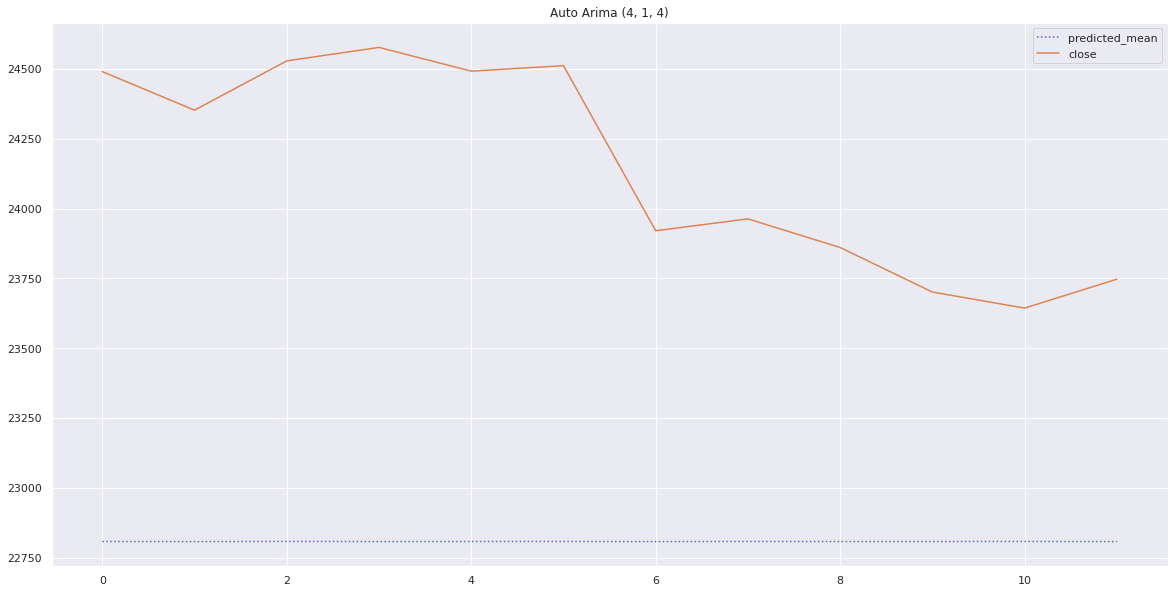


Evaluated model: Auto Arima (4, 1, 4)
Mean absolute error: 1341.7149975942057
Root mean squared error: 1388.2047802485433


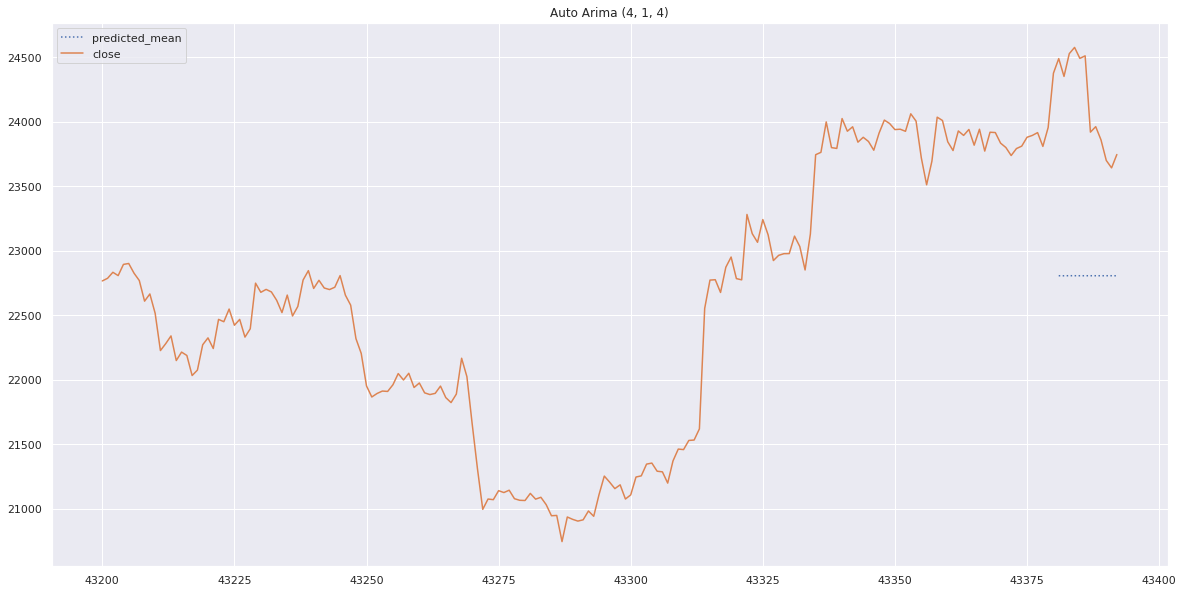

In [19]:
#train test todos los datos
df_train, df_test = df[0:-n_obs], df[-n_obs:]
#Fitting the model
model_ar = sm.tsa.arima.ARIMA(df_train.close, order = (4, 1, 4))
results_ar = model_ar.fit()
#Predictions
df_pred = results_ar.predict(start = start_date, end = end_date)
df_pred = df_pred.to_frame()
df_pred = df_pred.rename(columns = {0:'pred'})
#metrics
metric_df= pd.concat([df_pred, df1_test.reindex(df_pred.index)], axis=1)
show_graphp1(metric_df, 'Auto Arima (4, 1, 4)')

metric_df= pd.concat([df_pred, df1.reindex(df1.index)], axis=1)
show_graphp2(metric_df, 'Auto Arima (4, 1, 4)')

#Modelo AUTO ARIMA ajustando mas hiperparametros

In [ ]:
model_auto2 = auto_arima(df1_train, m = 5, max_order = None, max_p = 7, max_q = 7, max_d = 2, max_P = 4, max_Q = 4, max_D = 2, maxiter = 50, alpha = 0.05, n_jobs = -1, trend = 'ct', information_criterion = 'oob', out_of_sample_size = 72)


In [ ]:
model_auto2

In [ ]:
model_auto2.summary()

In [ ]:
#train test todos los datos
df_train, df_test = df[0:-n_obs], df[-n_obs:]
#Fitting the model
model_ar2 = sm.tsa.arima.ARIMA(order=(2, 1, 1), out_of_sample_size=8678, scoring_args={}, seasonal_order=(0, 0, 0, 5), suppress_warnings=True, trend='ct')
results_ar2 = model_ar2.fit()
#Predictions
df_pred = results_ar2.predict(start = start_date, end = end_date)
df_pred = df_pred.to_frame()
df_pred = df_pred.rename(columns = {0:'pred'})
#metrics
metric_df= pd.concat([df_pred, df1_test.reindex(df_pred.index)], axis=1)
show_graphp1(metric_df, 'Auto Arima 2')

metric_df= pd.concat([df_pred, df1.reindex(df1.index)], axis=1)
show_graphp2(metric_df, 'Auto Arima 2')

### Important Arguments

In [ ]:
model_auto2 = auto_arima(df_comp.ret_ftse[1:], exogenous = df_comp[['ret_spx', 'ret_dax', 'ret_nikkei']][1:], m = 5,
                       max_order = None, max_p = 7, max_q = 7, max_d = 2, max_P = 4, max_Q = 4, max_D = 2,
                       maxiter = 50, alpha = 0.05, n_jobs = -1, trend = 'ct', information_criterion = 'oob',
                       out_of_sample_size = int(len(df_comp)*0.2))


# exogenous -> outside factors (e.g other time series)
# m -> seasonal cycle length
# max_order -> maximum amount of variables to be used in the regression (p + q)
# max_p -> maximum AR components
# max_q -> maximum MA components
# max_d -> maximum Integrations
# maxiter -> maximum iterations we're giving the model to converge the coefficients (becomes harder as the order increases)
# alpha -> level of significance, default is 5%, which we should be using most of the time
# n_jobs -> how many models to fit at a time (-1 indicates "as many as possible")
# trend -> "ct" usually
# information_criterion -> 'aic', 'aicc', 'bic', 'hqic', 'oob' 
#        (Akaike Information Criterion, Corrected Akaike Information Criterion,
#        Bayesian Information Criterion, Hannan-Quinn Information Criterion, or
#        "out of bag"--for validation scoring--respectively)
# out_of_smaple_size -> validates the model selection (pass the entire dataset, and set 20% to be the out_of_sample_size)

In [ ]:
model_auto2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                       SARIMAX Results                                        
==============================================================================================
Dep. Variable:                                      y   No. Observations:                 6834
Model:             SARIMAX(2, 0, 1)x(0, 0, [1, 2], 5)   Log Likelihood              -10412.578
Date:                                Mon, 29 Aug 2022   AIC                          20841.156
Time:                                        17:23:51   BIC                          20895.794
Sample:                                             0   HQIC                         20860.006
                                               - 6834                                         
Covariance Type:                                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0298      0.030      1.003      0.316      -0.028       0.088
drift      -5.507e-06   7.89e-06     -0.698      0.485    -2.1e-05    9.96e-06
ar.L1       -7.24e-10      0.004  -1.85e-07      1.000      -0.008       0.008
ar.L2      -1.704e-09      0.007  -2.43e-07      1.000      -0.014       0.014
ma.L1      -7.228e-10      0.004  -1.85e-07      1.000      -0.008       0.008
ma.S.L5       -0.0523      0.007     -7.554      0.000      -0.066      -0.039
ma.S.L10      -0.0106      0.007     -1.440      0.150      -0.025       0.004
sigma2         1.3005      0.011    118.595      0.000       1.279       1.322
===================================================================================
Ljung-Box (L1) (Q):                   1.75   Jarque-Bera (JB):             16773.19
Prob(Q):                              0.19   Prob(JB):                         0.00
Heteroskedasticity (H):               0.76   Skew:                            -0.28
Prob(H) (two-sided):                  0.00   Kurtosis:                        10.65
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.06e+17. Standard errors may be unstable.
"""